In [1]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Hourly
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



In [2]:
# Set time period
start = datetime(2021, 12, 1)
end = datetime(2022, 12, 6)

# Create Point for Paris, BC
location = Point(48.856614, 2.333333)

data_=Hourly(location, start, end)
data_=data_.fetch()
#using reset_index() to set index into column
data_=data_.reset_index()
data_.rename( {'time':'date','temp':'temperature',
        'prcp':'total_precipitation_in_mm','snow':'snow_depth','tsun':'sunshine_minutes'}, axis=1, inplace=True)
data_=data_[['date', 'temperature', 'total_precipitation_in_mm',
       'snow_depth', 'sunshine_minutes']]


In [3]:
data_.head()

,date,temperature,total_precipitation_in_mm,snow_depth,sunshine_minutes
0,2021-12-01 00:00:00,9.1,0.0,NaN,NaN
1,2021-12-01 01:00:00,9.1,0.0,NaN,NaN
2,2021-12-01 02:00:00,9.1,0.0,NaN,NaN
3,2021-12-01 03:00:00,8.6,0.0,0.0,NaN
4,2021-12-01 04:00:00,9.1,0.8,NaN,NaN


In [4]:
data_.isnull().sum()

date                            0
temperature                     0
total_precipitation_in_mm       0
snow_depth                   6031
sunshine_minutes             8881
dtype: int64

In [5]:
data_.sunshine_minutes.value_counts()
data_.snow_depth.value_counts()

0.0    2850
Name: snow_depth, dtype: int64

In [6]:
data_.drop(['sunshine_minutes','snow_depth'],axis=1,inplace=True)

In [7]:
data_['date']=pd.to_datetime(data_['date'])

Get traffic data

In [8]:
sts_df=pd.read_csv('sts.csv',sep=';',parse_dates=['Date debut dispo data','Date et heure de comptage','Date fin dispo data'])
washington_df=pd.read_csv('washington.csv',sep=';',parse_dates=['Date debut dispo data','Date et heure de comptage','Date fin dispo data'])
convention_df=pd.read_csv('convention.csv',sep=';',parse_dates=['Date debut dispo data','Date et heure de comptage','Date fin dispo data'])

In [9]:
data_traffic=pd.concat([sts_df,washington_df,convention_df],axis=0)
data_traffic.head()

,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape
0,191,Sts_Peres,2022-01-02 22:00:00+01:00,345.0,3.85500,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.3324541907176717","{""coordinates"": [[2.3332577811, 48.858260067],..."
1,191,Sts_Peres,2022-01-02 20:00:00+01:00,482.0,5.92944,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.3324541907176717","{""coordinates"": [[2.3332577811, 48.858260067],..."
2,191,Sts_Peres,2022-01-02 23:00:00+01:00,260.0,3.10555,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.3324541907176717","{""coordinates"": [[2.3332577811, 48.858260067],..."
3,191,Sts_Peres,2022-01-02 17:00:00+01:00,523.0,10.19222,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.3324541907176717","{""coordinates"": [[2.3332577811, 48.858260067],..."
4,191,Sts_Peres,2022-01-02 13:00:00+01:00,422.0,5.34889,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.3324541907176717","{""coordinates"": [[2.3332577811, 48.858260067],..."


In [10]:
data_traffic['Date et heure de comptage']=pd.to_datetime(data_traffic['Date et heure de comptage'], utc=True)
data_traffic['Date et heure de comptage']=data_traffic['Date et heure de comptage'].dt.strftime('%Y-%m-%d %X') 
data_traffic['Date et heure de comptage']=pd.to_datetime(data_traffic['Date et heure de comptage'])


In [11]:
data_traffic.drop(columns=[
    'Identifiant noeud amont', 'Identifiant noeud aval', 'geo_point_2d',
    'geo_shape', 'Date debut dispo data', 'Date fin dispo data','Libelle noeud aval','Libelle noeud amont','Identifiant arc'],inplace=True,axis=1)
data_traffic=data_traffic.merge(data_,left_on='Date et heure de comptage',right_on='date',how='left')
data_traffic.drop(columns=['date'],inplace=True,axis=1)
data_traffic.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Etat arc,temperature,total_precipitation_in_mm
0,Sts_Peres,2022-01-02 21:00:00,345.0,3.85500,Fluide,Invalide,12.9,0.0
1,Sts_Peres,2022-01-02 19:00:00,482.0,5.92944,Fluide,Invalide,13.3,0.0
2,Sts_Peres,2022-01-02 22:00:00,260.0,3.10555,Fluide,Invalide,12.7,0.0
3,Sts_Peres,2022-01-02 16:00:00,523.0,10.19222,Fluide,Invalide,13.9,0.2
4,Sts_Peres,2022-01-02 12:00:00,422.0,5.34889,Fluide,Invalide,13.4,0.0


In [13]:
data_traffic['Date']=data_traffic['Date et heure de comptage'].dt.strftime('%Y-%m-%d')
data_traffic['Date']=pd.to_datetime(data_traffic['Date'])

data_traffic['Time']=data_traffic['Date et heure de comptage'].dt.strftime('%H').astype(int)
data_traffic['weekday']=data_traffic['Date et heure de comptage'].dt.weekday

In [14]:
holidays_list=holidays.France(years=[2021, 2022]).keys() # this is a dict
data_traffic.loc[data_traffic['Date'].isin(holidays_list),'holiday']=1
data_traffic['holiday'].fillna(0,inplace=True)
data_traffic.drop(columns=['Date'],inplace=True,axis=1)


In [15]:
data_traffic

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Etat arc,temperature,total_precipitation_in_mm,Time,weekday,holiday
0,Sts_Peres,2022-01-02 21:00:00,345.0,3.85500,Fluide,Invalide,12.9,0.0,21,6,0.0
1,Sts_Peres,2022-01-02 19:00:00,482.0,5.92944,Fluide,Invalide,13.3,0.0,19,6,0.0
2,Sts_Peres,2022-01-02 22:00:00,260.0,3.10555,Fluide,Invalide,12.7,0.0,22,6,0.0
3,Sts_Peres,2022-01-02 16:00:00,523.0,10.19222,Fluide,Invalide,13.9,0.2,16,6,0.0
4,Sts_Peres,2022-01-02 12:00:00,422.0,5.34889,Fluide,Invalide,13.4,0.0,12,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...
25179,Convention,2022-10-31 13:00:00,685.0,3.70889,Fluide,Invalide,20.3,0.0,13,0,0.0
25180,Convention,2022-08-01 01:00:00,140.0,0.68445,Fluide,Invalide,21.1,0.0,1,0,0.0
25181,Convention,2022-08-01 00:00:00,226.0,1.09111,Fluide,Invalide,21.1,0.0,0,0,0.0
25182,Convention,2022-07-31 23:00:00,267.0,1.47611,Fluide,Invalide,21.9,0.0,23,6,0.0


Encoding categorical columns

In [16]:
data_traffic['Etat trafic'].value_counts()

Fluide        18930
Pré-saturé     3557
Inconnu        1219
Saturé         1086
Bloqué          392
Name: Etat trafic, dtype: int64

In [17]:
mapper = {'Inconnu': 0, 'Fluide': 1, 'Pré-saturé': 2, 'Saturé': 3, 'Bloqué': 4}
data_traffic['Etat trafic'] = data_traffic['Etat trafic'].map(mapper)

In [18]:
data_traffic

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Etat arc,temperature,total_precipitation_in_mm,Time,weekday,holiday
0,Sts_Peres,2022-01-02 21:00:00,345.0,3.85500,1,Invalide,12.9,0.0,21,6,0.0
1,Sts_Peres,2022-01-02 19:00:00,482.0,5.92944,1,Invalide,13.3,0.0,19,6,0.0
2,Sts_Peres,2022-01-02 22:00:00,260.0,3.10555,1,Invalide,12.7,0.0,22,6,0.0
3,Sts_Peres,2022-01-02 16:00:00,523.0,10.19222,1,Invalide,13.9,0.2,16,6,0.0
4,Sts_Peres,2022-01-02 12:00:00,422.0,5.34889,1,Invalide,13.4,0.0,12,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...
25179,Convention,2022-10-31 13:00:00,685.0,3.70889,1,Invalide,20.3,0.0,13,0,0.0
25180,Convention,2022-08-01 01:00:00,140.0,0.68445,1,Invalide,21.1,0.0,1,0,0.0
25181,Convention,2022-08-01 00:00:00,226.0,1.09111,1,Invalide,21.1,0.0,0,0,0.0
25182,Convention,2022-07-31 23:00:00,267.0,1.47611,1,Invalide,21.9,0.0,23,6,0.0


<AxesSubplot: >

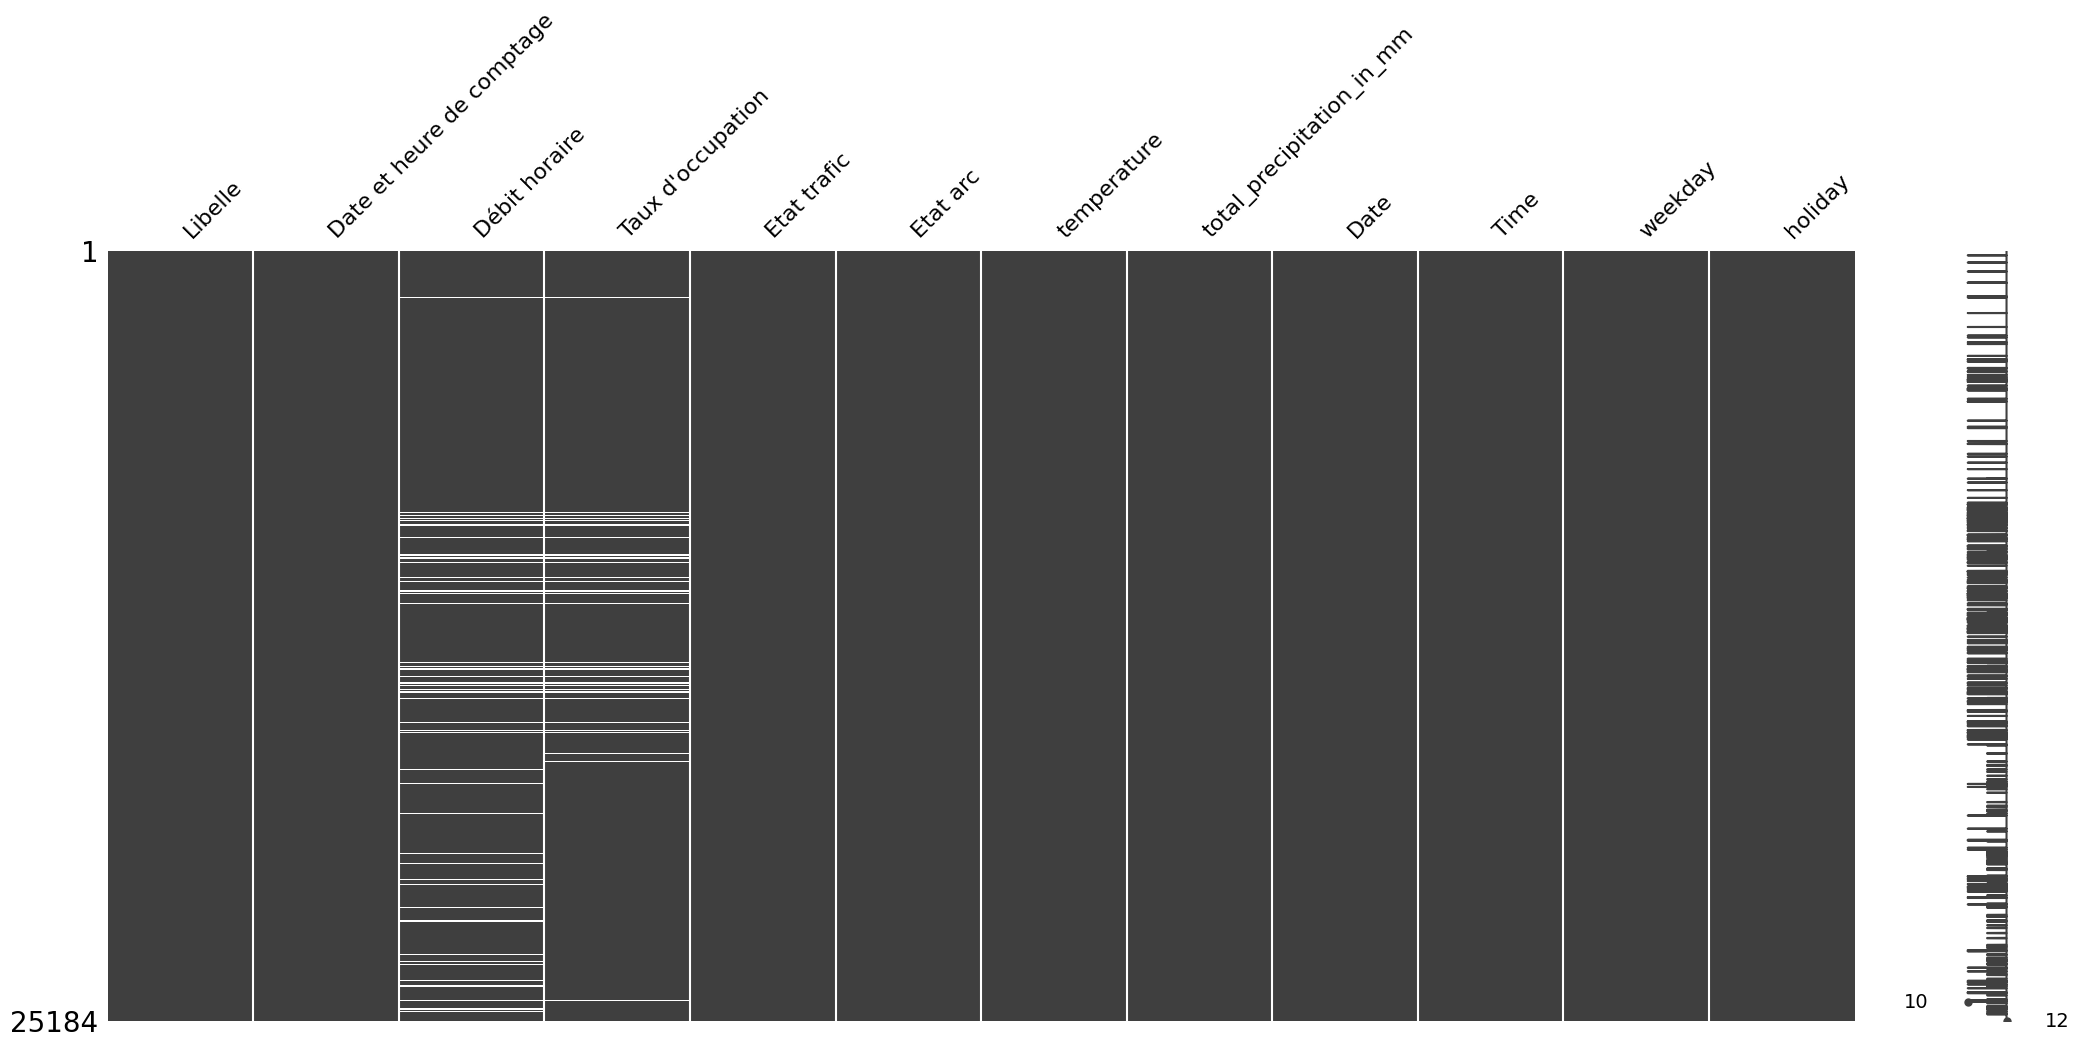

In [18]:
msno.matrix(data_traffic)


In [19]:
missingness=data_traffic.isnull().value_counts().to_frame()
missingness.head()

0
Libelle Date et heure de comptage Débit horaire Taux d'occupation Etat trafic Etat arc temperature total_precipitation_in_mm Date  Time  weekday holiday       
False   False                     False         False             False       False    False       False                     False False False   False    23277
                                  True          True              False       False    False       False                     False False False   False     1198
                                                False             False       False    False       False                     False False False   False      688
                                  False         True              False       False    False       False                     False False False   False       21

In [19]:
# imp_mean = IterativeImputer(random_state=0)   
# df_imputed = pd.DataFrame(imp_mean.fit_transform(data_traffic),columns=data_traffic.columns)
data_traffic['Débit horaire']=data_traffic['Débit horaire'].interpolate(method='linear')
data_traffic["Taux d'occupation"]=data_traffic["Taux d'occupation"].interpolate(method='linear')
data_traffic.isnull().sum()

Libelle                      0
Date et heure de comptage    0
Débit horaire                0
Taux d'occupation            0
Etat trafic                  0
Etat arc                     0
temperature                  0
total_precipitation_in_mm    0
Time                         0
weekday                      0
holiday                      0
dtype: int64

In [21]:
def imputer(df,strategy,order = 3):
    try:
        df = df.copy()
        df_imputed = None
        if strategy == 'IterativeImputer':
            imp_mean = IterativeImputer(random_state=0)   
            df_imputed = pd.DataFrame(imp_mean.fit_transform(df),columns=df.columns)
        elif strategy == 'LOCF':
            df_imputed = df.fillna(method='ffill').fillna(method='bfill')
        elif strategy == 'NOCB':
            df_imputed = df.fillna(method='bfill').fillna(method='ffill')
        elif strategy == 'linear_interpolation':
            df_imputed = df.interpolate(method='linear',limit_direction='both')
        elif strategy == 'spline_interpolation':
            df_imputed = df.interpolate(method='spline',order=order,limit_direction='both')
        else:
            raise ValueError("Error : The strategy '{}' is not supported".format(strategy))
        return df_imputed

    except ValueError as e:
        raise(e)
# Evaluate imputation using MSE AND MAE
def evaluate_imputation_mse(df: pd.DataFrame, df_imputed: pd.DataFrame, method_title: str) -> pd.DataFrame:
    mse = mean_squared_error(df.values, df_imputed, squared=True)
    mae = mean_absolute_error(df.values, df_imputed)
    result = pd.DataFrame({'method':method_title,'mse':mse, 'mae':mae}, index=[0])
    return result
    

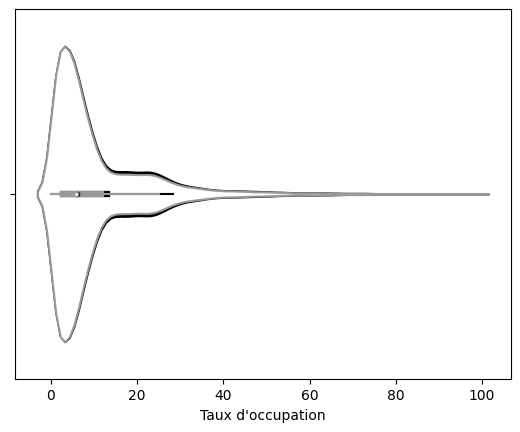

In [73]:
sns.violinplot(x="Taux d'occupation",data=copy_imputed,color='black')
sns.violinplot(x="Taux d'occupation",data=data_traffic,color='white')
#set edge color to black

plt.show()

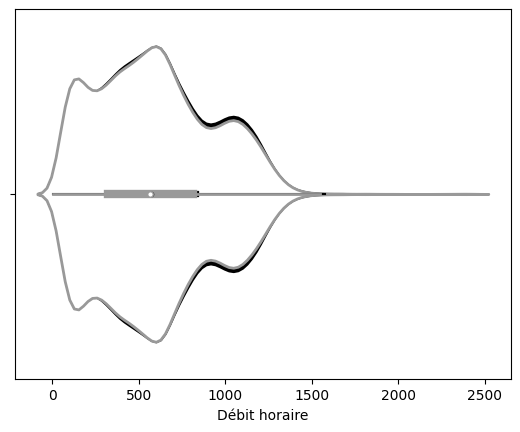

In [66]:
sns.violinplot(x='Débit horaire',data=copy_imputed,color='black')
sns.violinplot(x='Débit horaire',data=data_traffic,color='white',linewidth=2)
#set edge color to black

plt.show()


<AxesSubplot: >

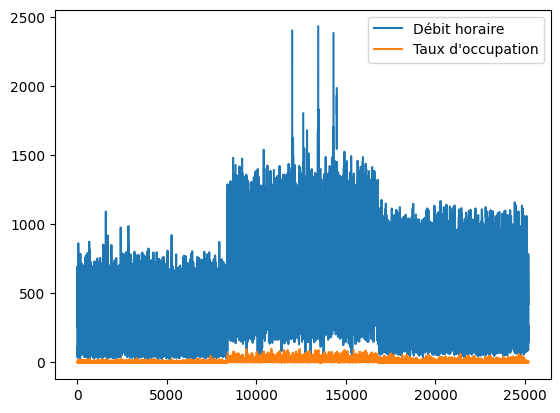

In [19]:
data_traffic[['Débit horaire', "Taux d'occupation"]].plot()


Libelle                         0
Date et heure de comptage       0
Débit horaire                1886
Taux d'occupation            1219
Etat trafic                     0
Etat arc                        0
date                            0
temperature                     0
total_precipitation_in_mm       0
dtype: int64